In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Project imports
from src.data_loader import load_and_filter_data
from src.preprocessing import split_features_labels
from src.feature_selection import select_top_features
from src.bayes_optimization import run_all_bayesian_optimizations
from src.optuna_optimization import optimize_with_optuna
from src.xai_interpretation import (
    explain_with_shap,
    explain_with_lime,
    plot_permutation_importance,
    plot_model_feature_importance,
    plot_elasticnet_weights
)

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

model_map = {
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "LGBM": LGBMClassifier,
    "XGB": XGBClassifier,
}

# ========================================
# 1. Load + preprocess data
# ========================================
data = load_and_filter_data()
X, y = split_features_labels(data)

# ========================================
# 2. Feature selection
# ========================================
X = X.copy()
selected_features = select_top_features(X, y, top_k=20)
X_selected = X[selected_features]

# ========================================
# 3. Run both optimization methods
# ========================================
print("🔍 Running Bayesian Optimization...")
bayes_results = run_all_bayesian_optimizations(X_selected, y)
print("✅ Done.\n")

print("🔍 Running Optuna Optimization...")
optuna_results = optimize_with_optuna(X_selected, y, n_trials=30)
print("✅ Done.\n")

combined = pd.concat([bayes_results, optuna_results], ignore_index=True)

# ========================================
# 4. Find best model across all results
# ========================================
best_model_info = combined.loc[combined['Best CV Score (ROC AUC)'].idxmax()]
best_model_name = best_model_info['Model']
best_params = best_model_info['Best Parameters']

# Cast types
if best_model_name == "RandomForest":
    best_params["n_estimators"] = int(best_params["n_estimators"])
    if isinstance(best_params.get("max_features", 1), float) and best_params["max_features"] > 1:
        best_params["max_features"] = float(best_params["max_features"])
elif best_model_name == "CatBoost":
    best_params["iterations"] = int(best_params["iterations"])
    best_params["depth"] = int(best_params["depth"])
elif best_model_name == "LGBM":
    best_params["n_estimators"] = int(best_params["n_estimators"])
elif best_model_name == "XGB":
    best_params["n_estimators"] = int(best_params["n_estimators"])
    best_params["max_depth"] = int(best_params["max_depth"])

print(f"🏆 Best Model: {best_model_name}")
print("🔧 Best Parameters:", best_params)

# ========================================
# 5. Cross-validated training & evaluation
# ========================================
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
auc_scores = []
final_model = model_map[best_model_name](**best_params)

for train_idx, test_idx in kf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

print(f"\n🎯 Mean ROC AUC (10-fold): {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



import os

# Create results directory
os.makedirs("results", exist_ok=True)

# Save selected features
with open("results/selected_features.txt", "w") as f:
    f.write("\n".join(selected_features))

# Save optimization results
bayes_results.to_csv("results/bayes_results.csv", index=False)
optuna_results.to_csv("results/optuna_results.csv", index=False)
combined.to_csv("results/final_summary.csv", index=False)

# Save final cross-val AUC
with open("results/final_auc.txt", "w") as f:
    f.write(f"Mean AUC: {np.mean(auc_scores):.4f}\n")
    f.write(f"Std AUC: {np.std(auc_scores):.4f}\n")
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Params: {best_params}\n")


🔍 Running Bayesian Optimization...
|   iter    |  target   | n_esti... | max_fe... |
-------------------------------------------------
| 1         | 0.7916363 | 106.18101 | 0.9556428 |
| 2         | 0.8119999 | 159.79909 | 0.6387926 |
| 3         | 0.8142727 | 73.402796 | 0.2403950 |
| 4         | 0.7962727 | 58.712541 | 0.8795585 |
| 5         | 0.7927272 | 140.16725 | 0.7372653 |
| 6         | 0.8036363 | 53.087674 | 0.9729188 |
| 7         | 0.8332727 | 174.86639 | 0.2911051 |
| 8         | 0.8248181 | 77.273745 | 0.2650640 |
| 9         | 0.8034545 | 95.636336 | 0.5722807 |
| 10        | 0.8028181 | 114.79175 | 0.3621062 |
| 11        | 0.7814545 | 182.06330 | 0.9650160 |
| 12        | 0.8219999 | 172.88162 | 0.1216336 |
| 13        | 0.7916363 | 176.62830 | 1.0       |
| 14        | 0.8158181 | 82.794918 | 0.4234503 |
| 15        | 0.8332727 | 174.87816 | 0.2782414 |
| 16        | 0.7762727 | 75.799788 | 0.8199511 |
| 17        | 0.8230909 | 174.08304 | 0.1       |
| 18        | 0

[I 2025-07-29 10:31:13,640] A new study created in memory with name: no-name-545e73cb-8de8-479c-b6c8-0cf05056969a


| 40        | 0.8110909 | 179.52723 | 0.1610677 | 4.5302988 |
✅ Done.

🔍 Running Optuna Optimization...
🔍 Optimizing RandomForest with Optuna...


[I 2025-07-29 10:31:17,114] Trial 0 finished with value: 0.8012727272727271 and parameters: {'n_estimators': 81, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8012727272727271.
[I 2025-07-29 10:31:17,770] Trial 1 finished with value: 0.8325454545454545 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8325454545454545.
[I 2025-07-29 10:31:18,284] Trial 2 finished with value: 0.796909090909091 and parameters: {'n_estimators': 103, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8325454545454545.
[I 2025-07-29 10:31:19,000] Trial 3 finished with value: 0.8258181818181818 and parameters: {'n_estimators': 132, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8325454545454545.
[I 2025-07-29 10:31:20,021] Trial 4 finished with value: 0.8194545454545455 and parameters: {'

🔍 Optimizing XGBoost with Optuna...


[I 2025-07-29 10:31:33,309] Trial 1 finished with value: 0.7552727272727273 and parameters: {'n_estimators': 98, 'max_depth': 4, 'learning_rate': 0.019676929297634677}. Best is trial 0 with value: 0.7876363636363636.
[I 2025-07-29 10:31:33,457] Trial 2 finished with value: 0.7994545454545455 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.2245329649850475}. Best is trial 2 with value: 0.7994545454545455.
[I 2025-07-29 10:31:33,782] Trial 3 finished with value: 0.7779999999999999 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.06642586327217075}. Best is trial 2 with value: 0.7994545454545455.
[I 2025-07-29 10:31:34,225] Trial 4 finished with value: 0.752 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.011287881197747755}. Best is trial 2 with value: 0.7994545454545455.
[I 2025-07-29 10:31:34,383] Trial 5 finished with value: 0.7707272727272728 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate'

🔍 Optimizing LGBM with Optuna...


[I 2025-07-29 10:31:39,364] Trial 0 finished with value: 0.7578181818181818 and parameters: {'n_estimators': 70, 'num_leaves': 93, 'learning_rate': 0.04104205217321744}. Best is trial 0 with value: 0.7578181818181818.
[I 2025-07-29 10:31:39,486] Trial 1 finished with value: 0.7974545454545454 and parameters: {'n_estimators': 181, 'num_leaves': 138, 'learning_rate': 0.11523825506406003}. Best is trial 1 with value: 0.7974545454545454.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 10:31:39,568] Trial 2 finished with value: 0.7772727272727273 and parameters: {'n_estimators': 51, 'num_leaves': 44, 'learning_rate': 0.09924110422452759}. Best is trial 1 with value: 0.7974545454545454.
[I 2025-07-29 10:31:39,627] Trial 3 finished with value: 0.8052727272727275 and parameters: {'n_estimators': 52, 'num_leaves': 46, 'learning_rate': 0.23197555944817064}. Best is trial 3 with value: 0.8052727272727275.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-07-29 10:31:39,749] Trial 4 finished with value: 0.7714545454545455 and parameters: {'n_estimators': 190, 'num_leaves': 109, 'learning_rate': 0.021693991806083956}. Best is trial 3 with value: 0.8052727272727275.
[I 2025-07-29 10:31:39,819] Trial 5 finished with value: 0.7976363636363637 and parameters: {'n_estimators': 81, 'num_leaves': 100, 'learning_rate': 0.22389040328376797}. Best is trial 3 with value: 0.8052727272727275.
[I 2025-07-29 10:31:39,887] Trial 6 finished with value: 0.7563636363636365 and parameters: {'n_estimators': 57, 'num_leaves': 148, 'learning_rate': 0.03922220068080942}. Best is trial 3 with value: 0.8052727272727275.


[LightGBM] [Info] Number of positive: 42, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-07-29 10:31:39,977] Trial 7 finished with value: 0.792 and parameters: {'n_estimators': 127, 'num_leaves': 116, 'learning_rate': 0.1218309854991151}. Best is trial 3 with value: 0.8052727272727275.
[I 2025-07-29 10:31:40,103] Trial 8 finished with value: 0.7921818181818183 and parameters: {'n_estimators': 159, 'num_leaves': 98, 'learning_rate': 0.10152382424999797}. Best is trial 3 with value: 0.8052727272727275.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 10:31:40,202] Trial 9 finished with value: 0.7438181818181817 and parameters: {'n_estimators': 102, 'num_leaves': 92, 'learning_rate': 0.010206366995629353}. Best is trial 3 with value: 0.8052727272727275.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 10:31:40,432] Trial 10 finished with value: 0.793818181818182 and parameters: {'n_estimators': 128, 'num_leaves': 26, 'learning_rate': 0.2622277255875844}. Best is trial 3 with value: 0.8052727272727275.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 10:31:40,577] Trial 11 finished with value: 0.8138181818181819 and parameters: {'n_estimators': 83, 'num_leaves': 58, 'learning_rate': 0.29833720769932554}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:40,674] Trial 12 finished with value: 0.798 and parameters: {'n_estimators': 94, 'num_leaves': 63, 'learning_rate': 0.27302796571573607}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 10:31:40,753] Trial 13 finished with value: 0.7834545454545454 and parameters: {'n_estimators': 105, 'num_leaves': 64, 'learning_rate': 0.17192370594607334}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:40,851] Trial 14 finished with value: 0.775090909090909 and parameters: {'n_estimators': 73, 'num_leaves': 61, 'learning_rate': 0.06631914598296483}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:40,917] Trial 15 finished with value: 0.7789090909090909 and parameters: {'n_estimators': 52, 'num_leaves': 22, 'learning_rate': 0.1782397025136576}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 10:31:41,035] Trial 16 finished with value: 0.7923636363636364 and parameters: {'n_estimators': 149, 'num_leaves': 46, 'learning_rate': 0.2893469540938798}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:41,125] Trial 17 finished with value: 0.7958181818181818 and parameters: {'n_estimators': 91, 'num_leaves': 79, 'learning_rate': 0.16319321609392204}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-29 10:31:41,226] Trial 18 finished with value: 0.7503636363636363 and parameters: {'n_estimators': 114, 'num_leaves': 40, 'learning_rate': 0.0230128912662317}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:41,334] Trial 19 finished with value: 0.7694545454545454 and parameters: {'n_estimators': 65, 'num_leaves': 76, 'learning_rate': 0.0635582440268829}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Info] Number of positive: 41, number of negative: 42[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further 

[I 2025-07-29 10:31:41,469] Trial 20 finished with value: 0.7898181818181819 and parameters: {'n_estimators': 84, 'num_leaves': 55, 'learning_rate': 0.19705486800126554}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:41,556] Trial 21 finished with value: 0.7923636363636364 and parameters: {'n_estimators': 94, 'num_leaves': 67, 'learning_rate': 0.2842152631776004}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Info] Number of positive: 41, number of negative: 42[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-07-29 10:31:41,647] Trial 22 finished with value: 0.7827272727272728 and parameters: {'n_estimators': 78, 'num_leaves': 52, 'learning_rate': 0.1372320042795444}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:41,734] Trial 23 finished with value: 0.8030909090909091 and parameters: {'n_estimators': 111, 'num_leaves': 33, 'learning_rate': 0.2995954812774146}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Info] Number of positive: 42, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506024 -> initscore=0.024098
[LightGBM] [Info] Start training from score 0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-07-29 10:31:41,824] Trial 24 finished with value: 0.7738181818181818 and parameters: {'n_estimators': 115, 'num_leaves': 37, 'learning_rate': 0.08037859910321757}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:41,930] Trial 25 finished with value: 0.7898181818181819 and parameters: {'n_estimators': 141, 'num_leaves': 32, 'learning_rate': 0.20988395601588744}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:42,000] Trial 26 finished with value: 0.7796363636363637 and parameters: {'n_estimators': 68, 'num_leaves': 28, 'learning_rate': 0.148119854908013}. Best is trial 11 with value: 0.8138181818181819.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 42, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[I 2025-07-29 10:31:42,134] Trial 27 finished with value: 0.7865454545454545 and parameters: {'n_estimators': 114, 'num_leaves': 51, 'learning_rate': 0.22478743106146157}. Best is trial 11 with value: 0.8138181818181819.


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 10:31:42,238] Trial 28 finished with value: 0.8030909090909091 and parameters: {'n_estimators': 62, 'num_leaves': 73, 'learning_rate': 0.2954156757243324}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:42,322] Trial 29 finished with value: 0.7541818181818183 and parameters: {'n_estimators': 72, 'num_leaves': 36, 'learning_rate': 0.04094510667826651}. Best is trial 11 with value: 0.8138181818181819.
[I 2025-07-29 10:31:42,331] A new study created in memory with name: no-name-caf56992-d059-451d-b941-743d7b64f904


[LightGBM] [Info] Number of positive: 41, number of negative: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493976 -> initscore=-0.024098
[LightGBM] [Info] Start training from score -0.024098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-07-29 10:31:47,345] Trial 0 finished with value: 0.7921818181818182 and parameters: {'iterations': 92, 'depth': 9, 'learning_rate': 0.28748008783610995}. Best is trial 0 with value: 0.7921818181818182.


90:	learn: 0.0097891	total: 780ms	remaining: 8.57ms
91:	learn: 0.0096914	total: 786ms	remaining: 0us
0:	learn: 0.6809844	total: 2.45ms	remaining: 378ms
0:	learn: 0.6858529	total: 2.74ms	remaining: 422ms
1:	learn: 0.6696059	total: 5.02ms	remaining: 384ms
1:	learn: 0.6780885	total: 4.38ms	remaining: 336ms
2:	learn: 0.6601816	total: 7.08ms	remaining: 359ms
2:	learn: 0.6719880	total: 6.1ms	remaining: 309ms
3:	learn: 0.6500904	total: 8.31ms	remaining: 314ms
3:	learn: 0.6625133	total: 8.23ms	remaining: 311ms
4:	learn: 0.6410648	total: 9.36ms	remaining: 281ms
4:	learn: 0.6574615	total: 8.99ms	remaining: 270ms
5:	learn: 0.6296275	total: 10.2ms	remaining: 254ms
5:	learn: 0.6494700	total: 10.3ms	remaining: 256ms
6:	learn: 0.6190274	total: 12.1ms	remaining: 255ms
6:	learn: 0.6386276	total: 12ms	remaining: 255ms
7:	learn: 0.6097483	total: 13.5ms	remaining: 249ms
7:	learn: 0.6295578	total: 13.1ms	remaining: 241ms
8:	learn: 0.6018931	total: 15.1ms	remaining: 245ms
8:	learn: 0.6223870	total: 14.6ms	r

[I 2025-07-29 10:31:48,640] Trial 1 finished with value: 0.8065454545454547 and parameters: {'iterations': 155, 'depth': 4, 'learning_rate': 0.017310216569129983}. Best is trial 1 with value: 0.8065454545454547.


94:	learn: 0.2736740	total: 135ms	remaining: 85.2ms
95:	learn: 0.2709909	total: 136ms	remaining: 83.3ms
96:	learn: 0.2686137	total: 136ms	remaining: 81.5ms
97:	learn: 0.2665997	total: 137ms	remaining: 79.7ms
98:	learn: 0.2631359	total: 138ms	remaining: 78ms
99:	learn: 0.2618092	total: 139ms	remaining: 76.2ms
100:	learn: 0.2606948	total: 139ms	remaining: 74.5ms
101:	learn: 0.2591357	total: 140ms	remaining: 72.8ms
102:	learn: 0.2558435	total: 141ms	remaining: 71.2ms
103:	learn: 0.2546000	total: 142ms	remaining: 69.5ms
104:	learn: 0.2531827	total: 142ms	remaining: 67.8ms
105:	learn: 0.2510194	total: 143ms	remaining: 66.2ms
106:	learn: 0.2495742	total: 144ms	remaining: 64.6ms
107:	learn: 0.2477887	total: 147ms	remaining: 63.8ms
108:	learn: 0.2461083	total: 147ms	remaining: 62.1ms
109:	learn: 0.2443588	total: 148ms	remaining: 60.6ms
110:	learn: 0.2421674	total: 149ms	remaining: 59.1ms
111:	learn: 0.2404772	total: 150ms	remaining: 57.6ms
112:	learn: 0.2386833	total: 151ms	remaining: 56ms
113

[I 2025-07-29 10:31:52,095] Trial 2 finished with value: 0.7634545454545455 and parameters: {'iterations': 128, 'depth': 8, 'learning_rate': 0.13892862520611005}. Best is trial 1 with value: 0.8065454545454547.


119:	learn: 0.0115591	total: 652ms	remaining: 43.5ms
120:	learn: 0.0114646	total: 656ms	remaining: 37.9ms
121:	learn: 0.0113715	total: 660ms	remaining: 32.4ms
122:	learn: 0.0112794	total: 665ms	remaining: 27ms
123:	learn: 0.0111891	total: 669ms	remaining: 21.6ms
124:	learn: 0.0111003	total: 672ms	remaining: 16.1ms
125:	learn: 0.0110132	total: 676ms	remaining: 10.7ms
126:	learn: 0.0109276	total: 679ms	remaining: 5.35ms
127:	learn: 0.0108436	total: 683ms	remaining: 0us
0:	learn: 0.6812113	total: 22.1ms	remaining: 2.85s
0:	learn: 0.6796232	total: 23.7ms	remaining: 3.06s
1:	learn: 0.6658323	total: 33ms	remaining: 2.11s
1:	learn: 0.6658339	total: 34.6ms	remaining: 2.21s
2:	learn: 0.6512158	total: 40.3ms	remaining: 1.71s
2:	learn: 0.6541078	total: 55.3ms	remaining: 2.34s
3:	learn: 0.6404489	total: 62.4ms	remaining: 1.97s
4:	learn: 0.6308379	total: 82ms	remaining: 2.05s
3:	learn: 0.6431442	total: 81.3ms	remaining: 2.56s
5:	learn: 0.6179116	total: 102ms	remaining: 2.12s
4:	learn: 0.6326310	tot

[I 2025-07-29 10:32:00,135] Trial 3 finished with value: 0.8205454545454545 and parameters: {'iterations': 130, 'depth': 10, 'learning_rate': 0.020831178192398075}. Best is trial 3 with value: 0.8205454545454545.


127:	learn: 0.1325339	total: 1.56s	remaining: 24.5ms
128:	learn: 0.1313411	total: 1.57s	remaining: 12.2ms
129:	learn: 0.1303526	total: 1.59s	remaining: 0us
0:	learn: 0.6805429	total: 22.7ms	remaining: 2.27s
0:	learn: 0.6820242	total: 31.2ms	remaining: 3.12s
1:	learn: 0.6676675	total: 37.5ms	remaining: 1.86s
1:	learn: 0.6676687	total: 41.8ms	remaining: 2.07s
2:	learn: 0.6539983	total: 45.5ms	remaining: 1.49s
3:	learn: 0.6441919	total: 69ms	remaining: 1.67s
2:	learn: 0.6567015	total: 78ms	remaining: 2.55s
4:	learn: 0.6351601	total: 89.4ms	remaining: 1.72s
3:	learn: 0.6464318	total: 106ms	remaining: 2.58s
5:	learn: 0.6229983	total: 118ms	remaining: 1.87s
4:	learn: 0.6365671	total: 134ms	remaining: 2.58s
5:	learn: 0.6229950	total: 138ms	remaining: 2.18s
6:	learn: 0.6132667	total: 134ms	remaining: 1.79s
6:	learn: 0.6121669	total: 156ms	remaining: 2.09s
7:	learn: 0.6032794	total: 174ms	remaining: 2.03s
7:	learn: 0.6018189	total: 204ms	remaining: 2.38s
8:	learn: 0.5934243	total: 223ms	remaini

[I 2025-07-29 10:32:06,664] Trial 4 finished with value: 0.8216363636363635 and parameters: {'iterations': 101, 'depth': 10, 'learning_rate': 0.019402906476119273}. Best is trial 4 with value: 0.8216363636363635.


0:	learn: 0.6282103	total: 2ms	remaining: 184ms
0:	learn: 0.6539567	total: 4.33ms	remaining: 398ms
1:	learn: 0.5731135	total: 3.87ms	remaining: 176ms
1:	learn: 0.6149840	total: 5.43ms	remaining: 247ms
2:	learn: 0.5313655	total: 4.93ms	remaining: 148ms
3:	learn: 0.4931525	total: 8.71ms	remaining: 194ms
2:	learn: 0.5871870	total: 8.73ms	remaining: 262ms
4:	learn: 0.4634620	total: 9.69ms	remaining: 171ms
3:	learn: 0.5456755	total: 10.8ms	remaining: 240ms
4:	learn: 0.5234277	total: 11.8ms	remaining: 207ms
5:	learn: 0.4261576	total: 14.8ms	remaining: 215ms
5:	learn: 0.4929549	total: 14ms	remaining: 202ms
6:	learn: 0.4058445	total: 17.6ms	remaining: 217ms
6:	learn: 0.4640295	total: 15.5ms	remaining: 191ms
7:	learn: 0.3742804	total: 20.7ms	remaining: 220ms
8:	learn: 0.3530052	total: 21.7ms	remaining: 202ms
7:	learn: 0.4337985	total: 18.1ms	remaining: 192ms
8:	learn: 0.4117856	total: 19.1ms	remaining: 178ms
9:	learn: 0.3383630	total: 22.7ms	remaining: 188ms
9:	learn: 0.3864190	total: 22.7ms	re

[I 2025-07-29 10:32:07,535] Trial 5 finished with value: 0.7798181818181817 and parameters: {'iterations': 93, 'depth': 4, 'learning_rate': 0.09789843304398138}. Best is trial 4 with value: 0.8216363636363635.


75:	learn: 0.0389359	total: 68.1ms	remaining: 15.2ms
76:	learn: 0.0382082	total: 69.2ms	remaining: 14.4ms
77:	learn: 0.0367420	total: 70ms	remaining: 13.5ms
78:	learn: 0.0357620	total: 70.9ms	remaining: 12.6ms
79:	learn: 0.0345775	total: 71.7ms	remaining: 11.7ms
80:	learn: 0.0337236	total: 72.6ms	remaining: 10.8ms
81:	learn: 0.0331204	total: 73.5ms	remaining: 9.85ms
82:	learn: 0.0326179	total: 74.3ms	remaining: 8.95ms
83:	learn: 0.0321518	total: 75.1ms	remaining: 8.05ms
84:	learn: 0.0315135	total: 76.1ms	remaining: 7.16ms
85:	learn: 0.0310486	total: 76.9ms	remaining: 6.26ms
86:	learn: 0.0306030	total: 77.9ms	remaining: 5.37ms
87:	learn: 0.0299724	total: 78.9ms	remaining: 4.48ms
88:	learn: 0.0296019	total: 79.9ms	remaining: 3.59ms
89:	learn: 0.0291707	total: 80.9ms	remaining: 2.7ms
90:	learn: 0.0287896	total: 81.6ms	remaining: 1.79ms
91:	learn: 0.0283181	total: 82.3ms	remaining: 894us
92:	learn: 0.0280236	total: 83.1ms	remaining: 0us
0:	learn: 0.6690231	total: 6.7ms	remaining: 456ms
0:	

[I 2025-07-29 10:32:08,709] Trial 6 finished with value: 0.8263636363636364 and parameters: {'iterations': 69, 'depth': 7, 'learning_rate': 0.03441930325215276}. Best is trial 6 with value: 0.8263636363636364.


62:	learn: 0.1676757	total: 355ms	remaining: 33.8ms
15:	learn: 0.4241032	total: 74ms	remaining: 245ms
63:	learn: 0.1652621	total: 359ms	remaining: 28ms
16:	learn: 0.4127641	total: 79.2ms	remaining: 242ms
17:	learn: 0.3998263	total: 81.3ms	remaining: 230ms
64:	learn: 0.1620930	total: 366ms	remaining: 22.5ms
65:	learn: 0.1598112	total: 371ms	remaining: 16.8ms
18:	learn: 0.3893669	total: 92.6ms	remaining: 244ms
66:	learn: 0.1572337	total: 373ms	remaining: 11.1ms
19:	learn: 0.3783330	total: 96.3ms	remaining: 236ms
20:	learn: 0.3691338	total: 99.3ms	remaining: 227ms
21:	learn: 0.3615493	total: 103ms	remaining: 221ms
67:	learn: 0.1548915	total: 385ms	remaining: 5.66ms
68:	learn: 0.1517389	total: 389ms	remaining: 0us
22:	learn: 0.3539287	total: 107ms	remaining: 215ms
23:	learn: 0.3449133	total: 112ms	remaining: 209ms
24:	learn: 0.3379735	total: 114ms	remaining: 201ms
25:	learn: 0.3287810	total: 117ms	remaining: 193ms
26:	learn: 0.3208211	total: 120ms	remaining: 186ms
27:	learn: 0.3136699	tota

[I 2025-07-29 10:32:12,844] Trial 7 finished with value: 0.8152727272727273 and parameters: {'iterations': 89, 'depth': 9, 'learning_rate': 0.059653633878830666}. Best is trial 6 with value: 0.8263636363636364.


73:	learn: 0.0718660	total: 517ms	remaining: 105ms
74:	learn: 0.0706125	total: 523ms	remaining: 97.6ms
75:	learn: 0.0694685	total: 530ms	remaining: 90.6ms
76:	learn: 0.0679748	total: 536ms	remaining: 83.6ms
77:	learn: 0.0668090	total: 543ms	remaining: 76.5ms
78:	learn: 0.0658254	total: 549ms	remaining: 69.5ms
79:	learn: 0.0649205	total: 555ms	remaining: 62.5ms
80:	learn: 0.0636942	total: 564ms	remaining: 55.7ms
81:	learn: 0.0627087	total: 570ms	remaining: 48.7ms
82:	learn: 0.0616227	total: 576ms	remaining: 41.7ms
83:	learn: 0.0605221	total: 586ms	remaining: 34.9ms
84:	learn: 0.0597131	total: 592ms	remaining: 27.9ms
85:	learn: 0.0588481	total: 602ms	remaining: 21ms
86:	learn: 0.0578651	total: 609ms	remaining: 14ms
87:	learn: 0.0569193	total: 616ms	remaining: 7ms
88:	learn: 0.0560921	total: 622ms	remaining: 0us
0:	learn: 0.5914979	total: 4.34ms	remaining: 681ms
0:	learn: 0.5306929	total: 3.26ms	remaining: 511ms
1:	learn: 0.4748363	total: 8.07ms	remaining: 629ms
1:	learn: 0.4088987	total:

[I 2025-07-29 10:32:14,716] Trial 8 finished with value: 0.7727272727272728 and parameters: {'iterations': 158, 'depth': 6, 'learning_rate': 0.2764365996997379}. Best is trial 6 with value: 0.8263636363636364.


102:	learn: 0.0035331	total: 304ms	remaining: 162ms
103:	learn: 0.0034919	total: 307ms	remaining: 159ms
104:	learn: 0.0034642	total: 311ms	remaining: 157ms
105:	learn: 0.0034354	total: 313ms	remaining: 154ms
106:	learn: 0.0033945	total: 319ms	remaining: 152ms
107:	learn: 0.0033543	total: 321ms	remaining: 149ms
108:	learn: 0.0033153	total: 323ms	remaining: 145ms
109:	learn: 0.0032796	total: 327ms	remaining: 142ms
110:	learn: 0.0032501	total: 329ms	remaining: 139ms
111:	learn: 0.0032259	total: 333ms	remaining: 137ms
112:	learn: 0.0032016	total: 336ms	remaining: 134ms
113:	learn: 0.0031676	total: 340ms	remaining: 131ms
114:	learn: 0.0031347	total: 344ms	remaining: 129ms
115:	learn: 0.0031033	total: 346ms	remaining: 125ms
116:	learn: 0.0030808	total: 350ms	remaining: 123ms
117:	learn: 0.0030497	total: 354ms	remaining: 120ms
118:	learn: 0.0030139	total: 359ms	remaining: 118ms
119:	learn: 0.0029850	total: 363ms	remaining: 115ms
120:	learn: 0.0029567	total: 369ms	remaining: 113ms
121:	learn: 

[I 2025-07-29 10:32:26,886] Trial 9 finished with value: 0.7587272727272728 and parameters: {'iterations': 184, 'depth': 10, 'learning_rate': 0.05169533554741609}. Best is trial 6 with value: 0.8263636363636364.


179:	learn: 0.0312484	total: 2.15s	remaining: 47.8ms
180:	learn: 0.0310833	total: 2.17s	remaining: 35.9ms
181:	learn: 0.0309240	total: 2.17s	remaining: 23.9ms
182:	learn: 0.0307537	total: 2.19s	remaining: 12ms
183:	learn: 0.0305890	total: 2.21s	remaining: 0us
0:	learn: 0.6888505	total: 2.36ms	remaining: 125ms
1:	learn: 0.6812375	total: 4.33ms	remaining: 113ms
2:	learn: 0.6754748	total: 6.24ms	remaining: 106ms
3:	learn: 0.6698773	total: 7.98ms	remaining: 99.8ms
0:	learn: 0.6862294	total: 5.66ms	remaining: 300ms
4:	learn: 0.6637452	total: 9.94ms	remaining: 97.4ms
5:	learn: 0.6568944	total: 11.6ms	remaining: 92.5ms
6:	learn: 0.6519307	total: 13.5ms	remaining: 90.8ms
7:	learn: 0.6458838	total: 15.1ms	remaining: 86.6ms
1:	learn: 0.6797452	total: 12.6ms	remaining: 326ms
8:	learn: 0.6399488	total: 16.7ms	remaining: 83.6ms
9:	learn: 0.6343818	total: 18.8ms	remaining: 82.9ms
10:	learn: 0.6282970	total: 20.3ms	remaining: 79.4ms
11:	learn: 0.6219112	total: 21.9ms	remaining: 76.6ms
12:	learn: 0.61

[I 2025-07-29 10:32:27,745] Trial 10 finished with value: 0.8114545454545455 and parameters: {'iterations': 54, 'depth': 6, 'learning_rate': 0.010152580766307918}. Best is trial 6 with value: 0.8263636363636364.


35:	learn: 0.5150279	total: 191ms	remaining: 95.5ms
18:	learn: 0.5752563	total: 78.5ms	remaining: 145ms
36:	learn: 0.5110029	total: 195ms	remaining: 89.6ms
19:	learn: 0.5707645	total: 81.2ms	remaining: 138ms
37:	learn: 0.5071303	total: 199ms	remaining: 83.8ms
20:	learn: 0.5655198	total: 85.2ms	remaining: 134ms
38:	learn: 0.5024627	total: 204ms	remaining: 78.4ms
21:	learn: 0.5589231	total: 89.7ms	remaining: 130ms
39:	learn: 0.4979108	total: 208ms	remaining: 72.7ms
22:	learn: 0.5540893	total: 93.3ms	remaining: 126ms
40:	learn: 0.4939769	total: 211ms	remaining: 66.9ms
41:	learn: 0.4909645	total: 215ms	remaining: 61.4ms
23:	learn: 0.5493387	total: 97.3ms	remaining: 122ms
42:	learn: 0.4850007	total: 217ms	remaining: 55.6ms
24:	learn: 0.5444298	total: 102ms	remaining: 118ms
43:	learn: 0.4809653	total: 221ms	remaining: 50.1ms
25:	learn: 0.5397184	total: 106ms	remaining: 115ms
44:	learn: 0.4771943	total: 225ms	remaining: 45ms
26:	learn: 0.5357421	total: 110ms	remaining: 110ms
45:	learn: 0.4737

[I 2025-07-29 10:32:28,922] Trial 11 finished with value: 0.8221818181818182 and parameters: {'iterations': 57, 'depth': 7, 'learning_rate': 0.030296175040434112}. Best is trial 6 with value: 0.8263636363636364.


35:	learn: 0.2926873	total: 106ms	remaining: 61.6ms
36:	learn: 0.2873502	total: 108ms	remaining: 58.3ms
37:	learn: 0.2820455	total: 110ms	remaining: 55ms
38:	learn: 0.2768823	total: 112ms	remaining: 51.7ms
39:	learn: 0.2726150	total: 114ms	remaining: 48.5ms
40:	learn: 0.2671553	total: 119ms	remaining: 46.4ms
41:	learn: 0.2609590	total: 122ms	remaining: 43.4ms
42:	learn: 0.2563390	total: 125ms	remaining: 40.8ms
43:	learn: 0.2517239	total: 128ms	remaining: 37.9ms
44:	learn: 0.2472674	total: 131ms	remaining: 34.9ms
45:	learn: 0.2428504	total: 134ms	remaining: 32.1ms
46:	learn: 0.2384835	total: 138ms	remaining: 29.3ms
47:	learn: 0.2361516	total: 140ms	remaining: 26.3ms
48:	learn: 0.2319405	total: 143ms	remaining: 23.4ms
49:	learn: 0.2273243	total: 146ms	remaining: 20.4ms
50:	learn: 0.2234097	total: 149ms	remaining: 17.5ms
51:	learn: 0.2206188	total: 151ms	remaining: 14.5ms
52:	learn: 0.2173120	total: 154ms	remaining: 11.6ms
53:	learn: 0.2143090	total: 157ms	remaining: 8.72ms
54:	learn: 0.2

[I 2025-07-29 10:32:30,134] Trial 12 finished with value: 0.8263636363636365 and parameters: {'iterations': 60, 'depth': 7, 'learning_rate': 0.03532855115409938}. Best is trial 12 with value: 0.8263636363636365.


44:	learn: 0.2171686	total: 120ms	remaining: 39.9ms
45:	learn: 0.2130065	total: 124ms	remaining: 37.8ms
46:	learn: 0.2087243	total: 128ms	remaining: 35.5ms
47:	learn: 0.2065568	total: 131ms	remaining: 32.7ms
48:	learn: 0.2026377	total: 133ms	remaining: 29.8ms
49:	learn: 0.1981649	total: 135ms	remaining: 27ms
50:	learn: 0.1942382	total: 137ms	remaining: 24.2ms
51:	learn: 0.1914374	total: 139ms	remaining: 21.4ms
52:	learn: 0.1893408	total: 141ms	remaining: 18.7ms
53:	learn: 0.1865327	total: 143ms	remaining: 15.9ms
54:	learn: 0.1839819	total: 146ms	remaining: 13.2ms
55:	learn: 0.1816606	total: 148ms	remaining: 10.6ms
56:	learn: 0.1788604	total: 150ms	remaining: 7.89ms
57:	learn: 0.1752922	total: 152ms	remaining: 5.24ms
58:	learn: 0.1729290	total: 154ms	remaining: 2.61ms
59:	learn: 0.1701922	total: 156ms	remaining: 0us
0:	learn: 0.6657572	total: 2.29ms	remaining: 158ms
1:	learn: 0.6410273	total: 6.27ms	remaining: 213ms
0:	learn: 0.6761186	total: 6.27ms	remaining: 433ms
2:	learn: 0.6110953	

[I 2025-07-29 10:32:31,181] Trial 13 finished with value: 0.8134545454545454 and parameters: {'iterations': 70, 'depth': 6, 'learning_rate': 0.040846668697877564}. Best is trial 12 with value: 0.8263636363636365.


55:	learn: 0.1565126	total: 237ms	remaining: 59.1ms
56:	learn: 0.1538495	total: 241ms	remaining: 55ms
57:	learn: 0.1510750	total: 245ms	remaining: 50.7ms
58:	learn: 0.1488436	total: 248ms	remaining: 46.3ms
59:	learn: 0.1467213	total: 251ms	remaining: 41.9ms
60:	learn: 0.1446754	total: 255ms	remaining: 37.6ms
61:	learn: 0.1419608	total: 258ms	remaining: 33.3ms
62:	learn: 0.1388281	total: 262ms	remaining: 29.1ms
63:	learn: 0.1359646	total: 265ms	remaining: 24.8ms
64:	learn: 0.1332092	total: 272ms	remaining: 20.9ms
65:	learn: 0.1307970	total: 276ms	remaining: 16.7ms
66:	learn: 0.1285994	total: 280ms	remaining: 12.5ms
67:	learn: 0.1262548	total: 284ms	remaining: 8.36ms
68:	learn: 0.1243466	total: 288ms	remaining: 4.17ms
69:	learn: 0.1222494	total: 292ms	remaining: 0us
0:	learn: 0.6260104	total: 8.65ms	remaining: 631ms
0:	learn: 0.6477102	total: 11.9ms	remaining: 866ms
1:	learn: 0.5830646	total: 15.1ms	remaining: 543ms
1:	learn: 0.5627635	total: 16.9ms	remaining: 609ms
2:	learn: 0.5139045	t

[I 2025-07-29 10:32:32,873] Trial 14 finished with value: 0.7963636363636363 and parameters: {'iterations': 74, 'depth': 7, 'learning_rate': 0.0990355084415055}. Best is trial 12 with value: 0.8263636363636365.


31:	learn: 0.1041880	total: 200ms	remaining: 263ms
32:	learn: 0.0998830	total: 204ms	remaining: 253ms
33:	learn: 0.0967420	total: 206ms	remaining: 242ms
34:	learn: 0.0934634	total: 208ms	remaining: 232ms
35:	learn: 0.0890119	total: 211ms	remaining: 223ms
36:	learn: 0.0859615	total: 214ms	remaining: 214ms
37:	learn: 0.0824808	total: 217ms	remaining: 205ms
38:	learn: 0.0801532	total: 219ms	remaining: 197ms
39:	learn: 0.0774878	total: 222ms	remaining: 188ms
40:	learn: 0.0748690	total: 224ms	remaining: 180ms
41:	learn: 0.0722216	total: 226ms	remaining: 172ms
42:	learn: 0.0699633	total: 228ms	remaining: 165ms
43:	learn: 0.0678114	total: 231ms	remaining: 157ms
44:	learn: 0.0661870	total: 233ms	remaining: 150ms
45:	learn: 0.0640710	total: 235ms	remaining: 143ms
46:	learn: 0.0617675	total: 237ms	remaining: 136ms
47:	learn: 0.0598163	total: 239ms	remaining: 130ms
48:	learn: 0.0581132	total: 241ms	remaining: 123ms
49:	learn: 0.0560837	total: 243ms	remaining: 117ms
50:	learn: 0.0533003	total: 246

[I 2025-07-29 10:32:34,112] Trial 15 finished with value: 0.8072727272727273 and parameters: {'iterations': 112, 'depth': 5, 'learning_rate': 0.031711549943946996}. Best is trial 12 with value: 0.8263636363636365.


55:	learn: 0.2303491	total: 80.3ms	remaining: 80.3ms
56:	learn: 0.2268903	total: 82.3ms	remaining: 79.4ms
57:	learn: 0.2230041	total: 85.1ms	remaining: 79.2ms
58:	learn: 0.2196346	total: 89.2ms	remaining: 80.1ms
59:	learn: 0.2155813	total: 91.9ms	remaining: 79.7ms
60:	learn: 0.2126147	total: 93.4ms	remaining: 78.1ms
61:	learn: 0.2111490	total: 94.8ms	remaining: 76.5ms
62:	learn: 0.2075075	total: 97.4ms	remaining: 75.8ms
63:	learn: 0.2043767	total: 99.3ms	remaining: 74.5ms
64:	learn: 0.2025986	total: 101ms	remaining: 73.1ms
65:	learn: 0.1985956	total: 103ms	remaining: 71.7ms
66:	learn: 0.1972590	total: 104ms	remaining: 69.9ms
67:	learn: 0.1941754	total: 106ms	remaining: 68.3ms
68:	learn: 0.1915700	total: 107ms	remaining: 66.9ms
69:	learn: 0.1891701	total: 109ms	remaining: 65.5ms
70:	learn: 0.1861796	total: 112ms	remaining: 64.9ms
71:	learn: 0.1824593	total: 115ms	remaining: 63.9ms
72:	learn: 0.1796541	total: 117ms	remaining: 62.6ms
73:	learn: 0.1769076	total: 119ms	remaining: 61.3ms
74:

[I 2025-07-29 10:32:36,081] Trial 16 finished with value: 0.7974545454545454 and parameters: {'iterations': 70, 'depth': 8, 'learning_rate': 0.07020241489341082}. Best is trial 12 with value: 0.8263636363636365.


61:	learn: 0.0686132	total: 240ms	remaining: 30.9ms
62:	learn: 0.0670365	total: 243ms	remaining: 27.1ms
63:	learn: 0.0656702	total: 247ms	remaining: 23.2ms
64:	learn: 0.0644311	total: 250ms	remaining: 19.3ms
65:	learn: 0.0630708	total: 255ms	remaining: 15.4ms
66:	learn: 0.0619605	total: 259ms	remaining: 11.6ms
67:	learn: 0.0605650	total: 262ms	remaining: 7.71ms
68:	learn: 0.0596717	total: 266ms	remaining: 3.86ms
69:	learn: 0.0585986	total: 270ms	remaining: 0us
0:	learn: 0.6883475	total: 3.83ms	remaining: 192ms
1:	learn: 0.6808488	total: 6.48ms	remaining: 159ms
2:	learn: 0.6742130	total: 9.42ms	remaining: 151ms
0:	learn: 0.6860169	total: 11.5ms	remaining: 574ms
3:	learn: 0.6677154	total: 13.2ms	remaining: 155ms
4:	learn: 0.6609519	total: 16.4ms	remaining: 151ms
5:	learn: 0.6558404	total: 19.3ms	remaining: 145ms
6:	learn: 0.6501447	total: 22.7ms	remaining: 143ms
7:	learn: 0.6439304	total: 26.2ms	remaining: 141ms
8:	learn: 0.6384393	total: 29.5ms	remaining: 138ms
1:	learn: 0.6784692	total

[I 2025-07-29 10:32:37,173] Trial 17 finished with value: 0.8130909090909091 and parameters: {'iterations': 51, 'depth': 7, 'learning_rate': 0.010048088164989965}. Best is trial 12 with value: 0.8263636363636365.


8:	learn: 0.6362826	total: 42.2ms	remaining: 197ms
9:	learn: 0.6301489	total: 44.3ms	remaining: 182ms
10:	learn: 0.6235602	total: 46.5ms	remaining: 169ms
11:	learn: 0.6182599	total: 48.7ms	remaining: 158ms
12:	learn: 0.6126088	total: 51ms	remaining: 149ms
13:	learn: 0.6070320	total: 53.7ms	remaining: 142ms
14:	learn: 0.6013831	total: 56.6ms	remaining: 136ms
15:	learn: 0.5964650	total: 58.7ms	remaining: 128ms
16:	learn: 0.5896266	total: 60.8ms	remaining: 122ms
17:	learn: 0.5843360	total: 62.9ms	remaining: 115ms
18:	learn: 0.5793336	total: 65ms	remaining: 109ms
19:	learn: 0.5752956	total: 67.2ms	remaining: 104ms
20:	learn: 0.5703753	total: 69.4ms	remaining: 99.1ms
21:	learn: 0.5651648	total: 71.5ms	remaining: 94.2ms
22:	learn: 0.5610958	total: 73.6ms	remaining: 89.6ms
23:	learn: 0.5557920	total: 75.8ms	remaining: 85.3ms
24:	learn: 0.5518971	total: 77.9ms	remaining: 81ms
25:	learn: 0.5474004	total: 80ms	remaining: 77ms
26:	learn: 0.5434078	total: 82.2ms	remaining: 73.1ms
27:	learn: 0.5389

[I 2025-07-29 10:32:39,211] Trial 18 finished with value: 0.8110909090909091 and parameters: {'iterations': 75, 'depth': 8, 'learning_rate': 0.029024855487826337}. Best is trial 12 with value: 0.8263636363636365.


58:	learn: 0.1982242	total: 226ms	remaining: 61.3ms
59:	learn: 0.1955328	total: 230ms	remaining: 57.4ms
60:	learn: 0.1926801	total: 233ms	remaining: 53.6ms
61:	learn: 0.1897818	total: 239ms	remaining: 50.1ms
62:	learn: 0.1869874	total: 243ms	remaining: 46.2ms
63:	learn: 0.1840350	total: 246ms	remaining: 42.4ms
64:	learn: 0.1811542	total: 250ms	remaining: 38.4ms
65:	learn: 0.1781314	total: 253ms	remaining: 34.6ms
66:	learn: 0.1753100	total: 258ms	remaining: 30.8ms
67:	learn: 0.1731539	total: 262ms	remaining: 27ms
68:	learn: 0.1707885	total: 266ms	remaining: 23.1ms
69:	learn: 0.1681914	total: 270ms	remaining: 19.3ms
70:	learn: 0.1659768	total: 274ms	remaining: 15.4ms
71:	learn: 0.1637105	total: 277ms	remaining: 11.6ms
72:	learn: 0.1613458	total: 283ms	remaining: 7.75ms
73:	learn: 0.1595101	total: 288ms	remaining: 3.89ms
74:	learn: 0.1573992	total: 291ms	remaining: 0us
0:	learn: 0.6826736	total: 1.25ms	remaining: 144ms
1:	learn: 0.6719524	total: 2.73ms	remaining: 156ms
2:	learn: 0.6606084

[I 2025-07-29 10:32:40,484] Trial 19 finished with value: 0.8203636363636365 and parameters: {'iterations': 116, 'depth': 5, 'learning_rate': 0.015413805995755668}. Best is trial 12 with value: 0.8263636363636365.


33:	learn: 0.4506661	total: 87.1ms	remaining: 210ms
34:	learn: 0.4460892	total: 88.3ms	remaining: 204ms
35:	learn: 0.4417403	total: 89.3ms	remaining: 198ms
36:	learn: 0.4384292	total: 90.3ms	remaining: 193ms
37:	learn: 0.4337107	total: 91.3ms	remaining: 187ms
38:	learn: 0.4287699	total: 92.5ms	remaining: 183ms
39:	learn: 0.4252744	total: 93.6ms	remaining: 178ms
40:	learn: 0.4214027	total: 94.5ms	remaining: 173ms
41:	learn: 0.4177696	total: 95.5ms	remaining: 168ms
42:	learn: 0.4146358	total: 98.5ms	remaining: 167ms
43:	learn: 0.4108831	total: 99.5ms	remaining: 163ms
44:	learn: 0.4070863	total: 101ms	remaining: 159ms
45:	learn: 0.4023927	total: 102ms	remaining: 155ms
46:	learn: 0.3980751	total: 103ms	remaining: 151ms
47:	learn: 0.3945271	total: 103ms	remaining: 147ms
48:	learn: 0.3913558	total: 104ms	remaining: 143ms
49:	learn: 0.3888127	total: 105ms	remaining: 139ms
50:	learn: 0.3852591	total: 107ms	remaining: 136ms
51:	learn: 0.3830339	total: 107ms	remaining: 132ms
52:	learn: 0.3794108

[I 2025-07-29 10:32:41,921] Trial 20 finished with value: 0.8038181818181819 and parameters: {'iterations': 142, 'depth': 5, 'learning_rate': 0.04483142393867742}. Best is trial 12 with value: 0.8263636363636365.


56:	learn: 0.1610756	total: 87.1ms	remaining: 130ms
57:	learn: 0.1577054	total: 88.4ms	remaining: 128ms
58:	learn: 0.1548360	total: 90.4ms	remaining: 127ms
59:	learn: 0.1514868	total: 91.8ms	remaining: 125ms
60:	learn: 0.1478793	total: 92.8ms	remaining: 123ms
61:	learn: 0.1466865	total: 94.1ms	remaining: 121ms
62:	learn: 0.1434551	total: 95.3ms	remaining: 119ms
63:	learn: 0.1409169	total: 96.3ms	remaining: 117ms
64:	learn: 0.1377615	total: 97.3ms	remaining: 115ms
65:	learn: 0.1350686	total: 98.3ms	remaining: 113ms
66:	learn: 0.1325894	total: 99.4ms	remaining: 111ms
67:	learn: 0.1296019	total: 100ms	remaining: 109ms
68:	learn: 0.1274498	total: 101ms	remaining: 107ms
69:	learn: 0.1245656	total: 102ms	remaining: 105ms
70:	learn: 0.1224324	total: 104ms	remaining: 104ms
71:	learn: 0.1193941	total: 105ms	remaining: 102ms
72:	learn: 0.1174922	total: 106ms	remaining: 100ms
73:	learn: 0.1159351	total: 108ms	remaining: 99.1ms
74:	learn: 0.1146857	total: 109ms	remaining: 97.6ms
75:	learn: 0.11349

[I 2025-07-29 10:32:43,355] Trial 21 finished with value: 0.8221818181818182 and parameters: {'iterations': 59, 'depth': 7, 'learning_rate': 0.030102595664506217}. Best is trial 12 with value: 0.8263636363636365.


54:	learn: 0.2212145	total: 467ms	remaining: 33.9ms
16:	learn: 0.4403267	total: 89.7ms	remaining: 222ms
17:	learn: 0.4278999	total: 94.2ms	remaining: 215ms
55:	learn: 0.2178868	total: 473ms	remaining: 25.4ms
18:	learn: 0.4177911	total: 102ms	remaining: 214ms
56:	learn: 0.2144688	total: 479ms	remaining: 16.8ms
19:	learn: 0.4071207	total: 106ms	remaining: 206ms
57:	learn: 0.2105801	total: 486ms	remaining: 8.37ms
20:	learn: 0.3981062	total: 111ms	remaining: 201ms
58:	learn: 0.2067843	total: 490ms	remaining: 0us
21:	learn: 0.3906282	total: 115ms	remaining: 194ms
22:	learn: 0.3831036	total: 119ms	remaining: 186ms
23:	learn: 0.3741960	total: 124ms	remaining: 181ms
24:	learn: 0.3673065	total: 127ms	remaining: 172ms
25:	learn: 0.3598909	total: 129ms	remaining: 163ms
26:	learn: 0.3519457	total: 131ms	remaining: 155ms
27:	learn: 0.3448201	total: 133ms	remaining: 147ms
28:	learn: 0.3365229	total: 135ms	remaining: 140ms
29:	learn: 0.3304642	total: 138ms	remaining: 134ms
30:	learn: 0.3248926	total:

[I 2025-07-29 10:32:45,421] Trial 22 finished with value: 0.8150909090909092 and parameters: {'iterations': 67, 'depth': 8, 'learning_rate': 0.026619211447753567}. Best is trial 12 with value: 0.8263636363636365.


58:	learn: 0.2150423	total: 335ms	remaining: 45.4ms
59:	learn: 0.2122267	total: 353ms	remaining: 41.2ms
60:	learn: 0.2097967	total: 367ms	remaining: 36.1ms
61:	learn: 0.2067686	total: 389ms	remaining: 31.3ms
62:	learn: 0.2036129	total: 416ms	remaining: 26.4ms
63:	learn: 0.2005418	total: 426ms	remaining: 20ms
64:	learn: 0.1975205	total: 429ms	remaining: 13.2ms
65:	learn: 0.1943409	total: 434ms	remaining: 6.58ms
66:	learn: 0.1913708	total: 438ms	remaining: 0us
0:	learn: 0.6668429	total: 1.64ms	remaining: 136ms
1:	learn: 0.6430438	total: 3.15ms	remaining: 129ms
2:	learn: 0.6141798	total: 5.74ms	remaining: 155ms
0:	learn: 0.6767957	total: 2.82ms	remaining: 234ms
3:	learn: 0.5929599	total: 8.36ms	remaining: 167ms
1:	learn: 0.6486012	total: 5.3ms	remaining: 217ms
4:	learn: 0.5768471	total: 11.1ms	remaining: 175ms
2:	learn: 0.6283361	total: 8.14ms	remaining: 220ms
5:	learn: 0.5598658	total: 14.1ms	remaining: 183ms
3:	learn: 0.6092938	total: 12.3ms	remaining: 247ms
6:	learn: 0.5411097	total: 1

[I 2025-07-29 10:32:46,760] Trial 23 finished with value: 0.8070909090909091 and parameters: {'iterations': 84, 'depth': 6, 'learning_rate': 0.03919336428020492}. Best is trial 12 with value: 0.8263636363636365.


66:	learn: 0.1344401	total: 172ms	remaining: 43.7ms
67:	learn: 0.1321397	total: 174ms	remaining: 41ms
68:	learn: 0.1304383	total: 176ms	remaining: 38.2ms
69:	learn: 0.1282569	total: 177ms	remaining: 35.5ms
70:	learn: 0.1270693	total: 179ms	remaining: 32.7ms
71:	learn: 0.1251337	total: 180ms	remaining: 30ms
72:	learn: 0.1230918	total: 181ms	remaining: 27.3ms
73:	learn: 0.1216446	total: 183ms	remaining: 24.7ms
74:	learn: 0.1190216	total: 185ms	remaining: 22.1ms
75:	learn: 0.1172682	total: 187ms	remaining: 19.6ms
76:	learn: 0.1158697	total: 188ms	remaining: 17.1ms
77:	learn: 0.1142512	total: 190ms	remaining: 14.6ms
78:	learn: 0.1117762	total: 191ms	remaining: 12.1ms
79:	learn: 0.1101708	total: 192ms	remaining: 9.62ms
80:	learn: 0.1085814	total: 194ms	remaining: 7.17ms
81:	learn: 0.1064990	total: 195ms	remaining: 4.76ms
82:	learn: 0.1049056	total: 197ms	remaining: 2.37ms
83:	learn: 0.1039020	total: 198ms	remaining: 0us
0:	learn: 0.6587842	total: 4.93ms	remaining: 246ms
1:	learn: 0.6085698	

[I 2025-07-29 10:32:47,886] Trial 24 finished with value: 0.8309090909090908 and parameters: {'iterations': 51, 'depth': 7, 'learning_rate': 0.07403699892052908}. Best is trial 24 with value: 0.8309090909090908.


15:	learn: 0.2789462	total: 82.4ms	remaining: 180ms
16:	learn: 0.2664811	total: 87.1ms	remaining: 174ms
17:	learn: 0.2537053	total: 91.3ms	remaining: 167ms
18:	learn: 0.2426448	total: 95.3ms	remaining: 161ms
19:	learn: 0.2328635	total: 98.3ms	remaining: 152ms
20:	learn: 0.2231594	total: 101ms	remaining: 145ms
21:	learn: 0.2161360	total: 105ms	remaining: 138ms
22:	learn: 0.2064297	total: 108ms	remaining: 132ms
23:	learn: 0.1995218	total: 112ms	remaining: 125ms
24:	learn: 0.1919290	total: 115ms	remaining: 119ms
25:	learn: 0.1834967	total: 120ms	remaining: 115ms
26:	learn: 0.1764261	total: 123ms	remaining: 109ms
27:	learn: 0.1716421	total: 126ms	remaining: 103ms
28:	learn: 0.1640483	total: 129ms	remaining: 98.2ms
29:	learn: 0.1569417	total: 132ms	remaining: 92.7ms
30:	learn: 0.1524173	total: 135ms	remaining: 87.4ms
31:	learn: 0.1474554	total: 139ms	remaining: 82.6ms
32:	learn: 0.1426558	total: 142ms	remaining: 77.6ms
33:	learn: 0.1394058	total: 148ms	remaining: 74.2ms
34:	learn: 0.1352550

[I 2025-07-29 10:32:51,214] Trial 25 finished with value: 0.7894545454545454 and parameters: {'iterations': 195, 'depth': 7, 'learning_rate': 0.07151668338480846}. Best is trial 24 with value: 0.8309090909090908.


124:	learn: 0.0220468	total: 366ms	remaining: 205ms
125:	learn: 0.0217777	total: 370ms	remaining: 203ms
126:	learn: 0.0214966	total: 372ms	remaining: 199ms
127:	learn: 0.0212473	total: 375ms	remaining: 196ms
128:	learn: 0.0210078	total: 378ms	remaining: 193ms
129:	learn: 0.0207920	total: 382ms	remaining: 191ms
130:	learn: 0.0205590	total: 385ms	remaining: 188ms
131:	learn: 0.0203520	total: 387ms	remaining: 185ms
132:	learn: 0.0201506	total: 389ms	remaining: 181ms
133:	learn: 0.0199377	total: 391ms	remaining: 178ms
134:	learn: 0.0197450	total: 393ms	remaining: 175ms
135:	learn: 0.0195564	total: 396ms	remaining: 172ms
136:	learn: 0.0193721	total: 398ms	remaining: 168ms
137:	learn: 0.0191921	total: 400ms	remaining: 165ms
138:	learn: 0.0190160	total: 402ms	remaining: 162ms
139:	learn: 0.0188263	total: 404ms	remaining: 159ms
140:	learn: 0.0186585	total: 407ms	remaining: 156ms
141:	learn: 0.0184949	total: 409ms	remaining: 153ms
142:	learn: 0.0183200	total: 411ms	remaining: 149ms
143:	learn: 

[I 2025-07-29 10:32:52,534] Trial 26 finished with value: 0.7687272727272727 and parameters: {'iterations': 50, 'depth': 8, 'learning_rate': 0.13426564656257184}. Best is trial 24 with value: 0.8309090909090908.


44:	learn: 0.0440885	total: 208ms	remaining: 23.1ms
45:	learn: 0.0423862	total: 211ms	remaining: 18.4ms
46:	learn: 0.0409804	total: 215ms	remaining: 13.7ms
47:	learn: 0.0396416	total: 220ms	remaining: 9.16ms
48:	learn: 0.0385583	total: 224ms	remaining: 4.56ms
49:	learn: 0.0376155	total: 227ms	remaining: 0us
0:	learn: 0.6409860	total: 14ms	remaining: 1.48s
0:	learn: 0.6340834	total: 11.9ms	remaining: 1.26s
1:	learn: 0.5933660	total: 26.4ms	remaining: 1.39s
1:	learn: 0.5850021	total: 23.4ms	remaining: 1.23s
2:	learn: 0.5442371	total: 39.4ms	remaining: 1.36s
2:	learn: 0.5394464	total: 39.1ms	remaining: 1.35s
3:	learn: 0.5078255	total: 50ms	remaining: 1.29s
3:	learn: 0.5026543	total: 49.4ms	remaining: 1.27s
4:	learn: 0.4762127	total: 60.1ms	remaining: 1.23s
4:	learn: 0.4636925	total: 62.7ms	remaining: 1.28s
5:	learn: 0.4447873	total: 67.4ms	remaining: 1.14s
5:	learn: 0.4298226	total: 74.9ms	remaining: 1.26s
6:	learn: 0.4128088	total: 77.9ms	remaining: 1.11s
6:	learn: 0.4009601	total: 85.6m

[I 2025-07-29 10:32:57,986] Trial 27 finished with value: 0.7696363636363637 and parameters: {'iterations': 107, 'depth': 9, 'learning_rate': 0.09460548890400865}. Best is trial 24 with value: 0.8309090909090908.


101:	learn: 0.0267392	total: 951ms	remaining: 46.6ms
102:	learn: 0.0264293	total: 957ms	remaining: 37.2ms
103:	learn: 0.0261578	total: 963ms	remaining: 27.8ms
104:	learn: 0.0258941	total: 970ms	remaining: 18.5ms
105:	learn: 0.0255967	total: 976ms	remaining: 9.21ms
106:	learn: 0.0253562	total: 982ms	remaining: 0us
0:	learn: 0.5842456	total: 1.82ms	remaining: 141ms
0:	learn: 0.6251918	total: 1.52ms	remaining: 117ms
1:	learn: 0.4923377	total: 3.83ms	remaining: 146ms
1:	learn: 0.5403194	total: 4.38ms	remaining: 166ms
2:	learn: 0.4267468	total: 6.77ms	remaining: 169ms
2:	learn: 0.4807024	total: 6.46ms	remaining: 161ms
3:	learn: 0.3770524	total: 9.82ms	remaining: 182ms
3:	learn: 0.4265681	total: 9.28ms	remaining: 172ms
4:	learn: 0.3747351	total: 10.8ms	remaining: 158ms
4:	learn: 0.3387170	total: 15.7ms	remaining: 230ms
5:	learn: 0.3400308	total: 13.3ms	remaining: 159ms
6:	learn: 0.3136665	total: 14.7ms	remaining: 149ms
7:	learn: 0.2734992	total: 16.4ms	remaining: 143ms
5:	learn: 0.3103184	to

[I 2025-07-29 10:32:58,929] Trial 28 finished with value: 0.7758181818181819 and parameters: {'iterations': 78, 'depth': 6, 'learning_rate': 0.17478295060767154}. Best is trial 24 with value: 0.8309090909090908.


60:	learn: 0.0167681	total: 225ms	remaining: 62.7ms
61:	learn: 0.0163123	total: 228ms	remaining: 58.7ms
62:	learn: 0.0158378	total: 229ms	remaining: 54.6ms
2:	learn: 0.4267165	total: 20.4ms	remaining: 509ms
63:	learn: 0.0153790	total: 231ms	remaining: 50.6ms
64:	learn: 0.0147944	total: 233ms	remaining: 46.7ms
65:	learn: 0.0144757	total: 235ms	remaining: 42.8ms
3:	learn: 0.3779111	total: 27ms	remaining: 500ms
66:	learn: 0.0141849	total: 238ms	remaining: 39ms
67:	learn: 0.0137852	total: 240ms	remaining: 35.3ms
68:	learn: 0.0135071	total: 241ms	remaining: 31.5ms
4:	learn: 0.3226036	total: 32.8ms	remaining: 479ms
69:	learn: 0.0132014	total: 243ms	remaining: 27.8ms
70:	learn: 0.0128029	total: 245ms	remaining: 24.2ms
5:	learn: 0.2978080	total: 36.7ms	remaining: 440ms
71:	learn: 0.0125623	total: 250ms	remaining: 20.9ms
6:	learn: 0.2669326	total: 40.9ms	remaining: 415ms
72:	learn: 0.0123451	total: 254ms	remaining: 17.4ms
7:	learn: 0.2395118	total: 44.1ms	remaining: 386ms
73:	learn: 0.0121381	t

[I 2025-07-29 10:33:00,378] Trial 29 finished with value: 0.8145454545454545 and parameters: {'iterations': 97, 'depth': 7, 'learning_rate': 0.05772687762205266}. Best is trial 24 with value: 0.8309090909090908.


44:	learn: 0.1293792	total: 132ms	remaining: 153ms
45:	learn: 0.1266108	total: 135ms	remaining: 150ms
46:	learn: 0.1247282	total: 138ms	remaining: 147ms
47:	learn: 0.1218413	total: 141ms	remaining: 144ms
48:	learn: 0.1187573	total: 143ms	remaining: 140ms
49:	learn: 0.1156303	total: 145ms	remaining: 136ms
50:	learn: 0.1135236	total: 147ms	remaining: 133ms
51:	learn: 0.1105104	total: 149ms	remaining: 129ms
52:	learn: 0.1091330	total: 151ms	remaining: 126ms
53:	learn: 0.1068155	total: 154ms	remaining: 122ms
54:	learn: 0.1037887	total: 156ms	remaining: 119ms
55:	learn: 0.1017828	total: 158ms	remaining: 116ms
56:	learn: 0.0995747	total: 162ms	remaining: 114ms
57:	learn: 0.0974296	total: 165ms	remaining: 111ms
58:	learn: 0.0949775	total: 168ms	remaining: 108ms
59:	learn: 0.0932709	total: 170ms	remaining: 105ms
60:	learn: 0.0907884	total: 174ms	remaining: 102ms
61:	learn: 0.0885279	total: 176ms	remaining: 99.6ms
62:	learn: 0.0866343	total: 179ms	remaining: 96.6ms
63:	learn: 0.0847488	total: 1

In [38]:
import shap

final_model.fit(X_selected, y)
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_selected)


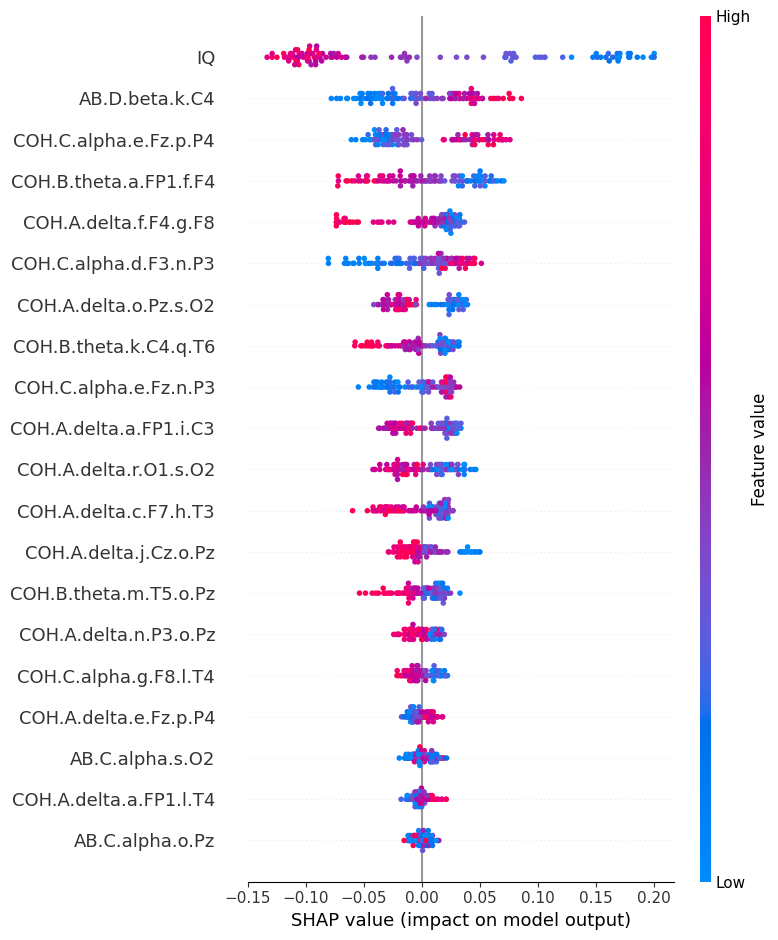

In [39]:
shap.summary_plot(shap_values[:, :, 1], X_selected)

In [ ]:
shap.dependence_plot('IQ', shap_values[:, :, 1], X_selected)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [40]:
import matplotlib.pyplot as plt

plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_selected, show=False)
plt.savefig("results/shap_summary_plot.png", bbox_inches="tight")
plt.close()